<div>
<h1>Autocorrelation Phase Matrix Homework</h1> 
</div>

Follow the instructions in the document. 

Print, plot and play (when possible) all the intermediate results that you obtain in a readable format.

Please, use the proposed variables names for the output of each section.

### Import your libraries here

In [61]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp
from scipy.signal import find_peaks

### Define utilities functions

In [62]:
def warp(x, low, interval):
    return np.remainder(x - low, interval) + low


def princarg(x):
    return warp(x, -np.pi, 2*np.pi)


def compute_novelty(x, Fs=1, N=512, H=256):
    """Compute complex-domain novelty function
    """     
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs/H
    mag = np.abs(X)
    
    phase = np.angle(X)/(2*np.pi)
    
    unwr_phase = np.zeros_like(X, dtype=float);
    for i in np.arange(X.shape[1]):
        unwr_phase[:,i] = np.unwrap( np.angle(X[:,i]) )
    
    phase_shift = unwr_phase[:,2:] - 2*unwr_phase[:,1:-1] + unwr_phase[:,0:-2]
    phase_shift = princarg(phase_shift)    
    
    
    amp_pred = mag[:,1:-1]
    amp_true = mag[:,2:]
    
    novelty_complex = (amp_pred**2 + amp_true**2 - 2 * amp_pred * amp_true * np.cos(phase_shift))
    
    # Half wave rectification
    novelty_complex[novelty_complex<0]=0
    
    novelty_complex = np.sqrt(novelty_complex)
    
    novelty_complex = np.sum(novelty_complex, axis=0)
    novelty_complex = np.concatenate((novelty_complex, np.array([0, 0])))
    
    return novelty_complex, Fs_feature

In [63]:
def compute_APM(x, lags):
    N = len(x)
    n_lags = len(lags)
    max_lag = lags[-1]                   
    P = np.zeros((n_lags, max_lag))
    
    for lag_index in np.arange(n_lags):
        k = lags[lag_index]                   
        for phi in np.arange(k):
            n = np.ceil((N-phi)/k)
            i = np.array(phi + k*np.arange(n), dtype=int) 
            P[lag_index,phi] = np.sum(x[i[0:-1]] * x[i[1:]])
            
    return P

In [64]:
#def compute_APM(x, lags):
#    N = len(x)
#    n_lags = len(lags)
#    max_lag = lags[-1]                   
#    P = np.zeros((n_lags, max_lag))
#    C = np.zeros((n_lags, max_lag))
#
#    for lag_index in np.arange(n_lags):
#        k = lags[lag_index]                   
#        for phi in np.arange(k):
#            n = np.ceil((N-phi)/k)
#            i = np.array(phi + k*np.arange(n), dtype=int) 
#            P[lag_index,phi] = np.sum(x[i[0:-1]] * x[i[1:]])
#            C[lag_index,phi] = n-1                               
#    C[C==0]=1 
#
#    return P

In [65]:
def smooth(x, win_length=11, win_type='boxcar'):
    if x.ndim != 1:
        raise ValueError('smooth only accepts 1 dimension arrays.')

    if x.size < win_length:
        raise ValueError('Input vector needs to be bigger than window size.')

    if win_length<3:
        return x
    # mirror pad
    s = np.pad(x, int(win_length/2), mode='reflect')    
    # create window
    w = sp.signal.windows.get_window(win_type, win_length)
    # convolve with normalized window
    y=np.convolve(w/w.sum(), s, mode='valid')
    
    #normalize
    y=y/(np.max(y))
    
    #padding for garantee the same len of x and y
    pad_width = len(y) - len(x)
    y = np.pad(y, pad_width)
    
    # return the useful part of y
    return y

## Input preparation

### Define audio signals

In [66]:
#Time arrays definition
x_times = np.arange(0,2,0.5)
y_times = np.arange(0,2,2/3)
Fs=22050

In [67]:
#Generate Clicks
x = librosa.clicks(sr=Fs, click_duration=0.5, times=x_times)
y = librosa.clicks(sr=Fs, click_duration=2/3, times=y_times)
z = np.sum((x,y), axis=0)

In [68]:
#Listen the signals
ipd.display(ipd.Audio(x, rate=Fs))
ipd.display(ipd.Audio(y, rate=Fs))
ipd.display(ipd.Audio(z, rate=Fs))

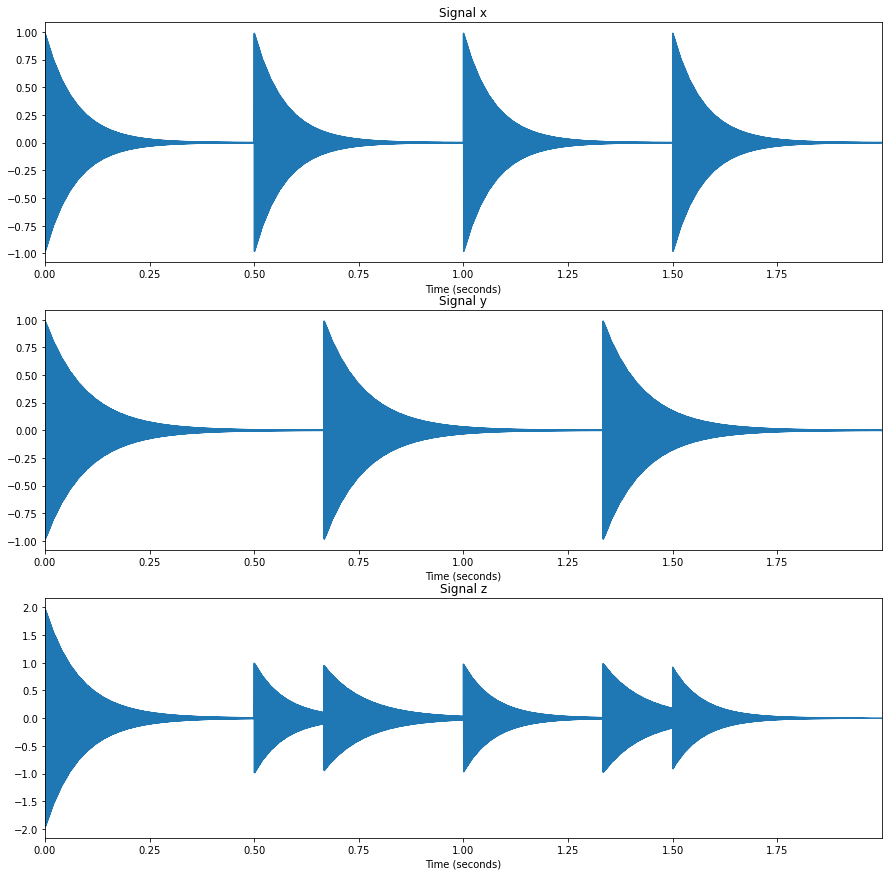

In [69]:
#Plot the signals
feature_time_axis = np.arange(z.shape[0]) / Fs

plt.figure(figsize=(15, 15))
plt.subplot(3,1,1)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Signal x')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, x)

plt.subplot(3,1,2)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Signal y')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, y)

plt.subplot(3,1,3)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Signal z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, z)

plt.show()

### Compute novelty curves

In [70]:
nov_x, Fs_nov = compute_novelty(x,Fs=Fs)
nov_y, Fs_nov = compute_novelty(y,Fs=Fs)
nov_z, Fs_nov = compute_novelty(z,Fs=Fs)

#Nomalization
nov_x = nov_x/(np.max(nov_x))
nov_y = nov_y/(np.max(nov_y))
nov_z = nov_z/(np.max(nov_z))

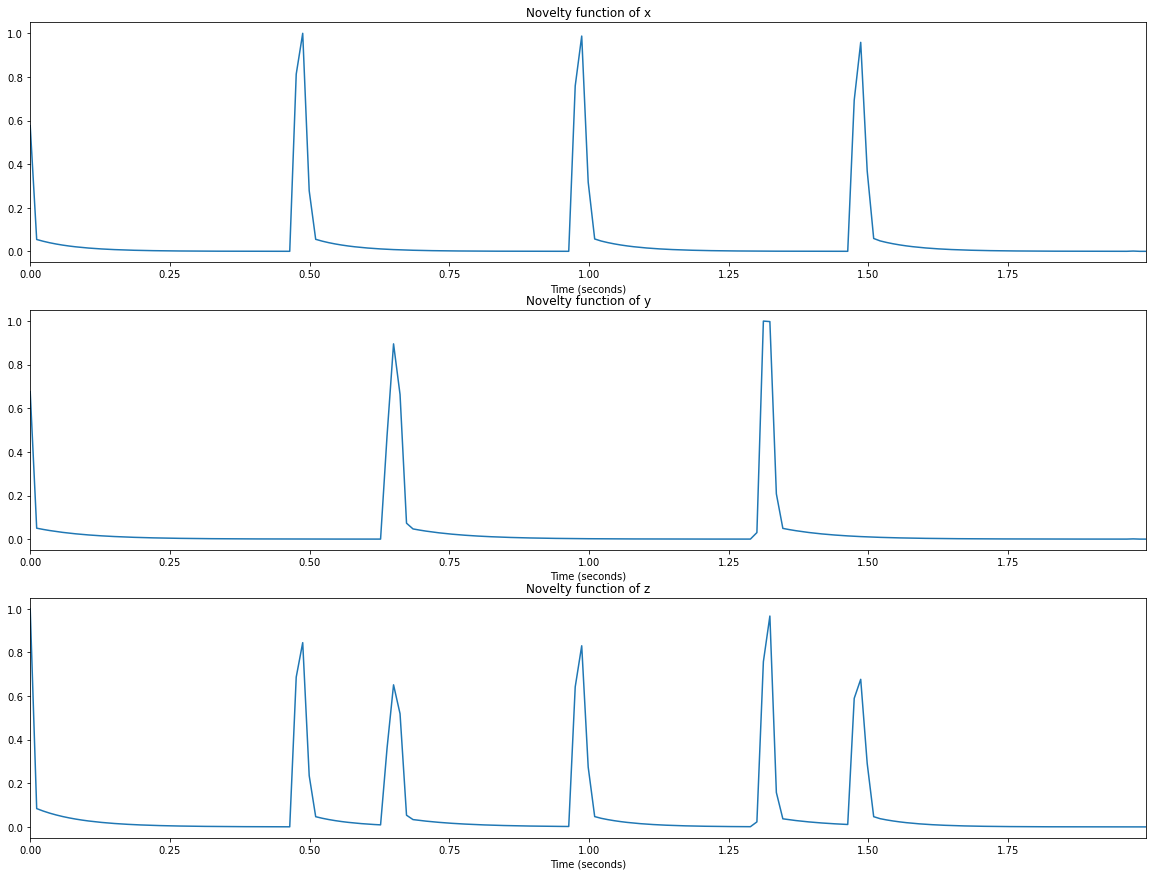

In [71]:
#Novelty function plot
feature_time_axis = np.arange(nov_z.shape[0]) / Fs_nov

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Novelty function of x')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, nov_x)

plt.subplot(3,1,2)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Novelty function of y')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, nov_y)

plt.subplot(3,1,3)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Novelty function of z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, nov_z)

plt.show()

## Autocorrelation Phase Matrix Parameters

In [72]:
#K lags found
kmin = 19
kmax = 130
lags = np.arange(kmin,kmax)

## Autocorrelation Phase Matrix Computation

### Apply smoothing

In [73]:
#Apply the modified smooth function
smooth_nov_x = smooth(nov_x,win_length=4)
smooth_nov_y = smooth(nov_y,win_length=4)
smooth_nov_z = smooth(nov_z,win_length=4)

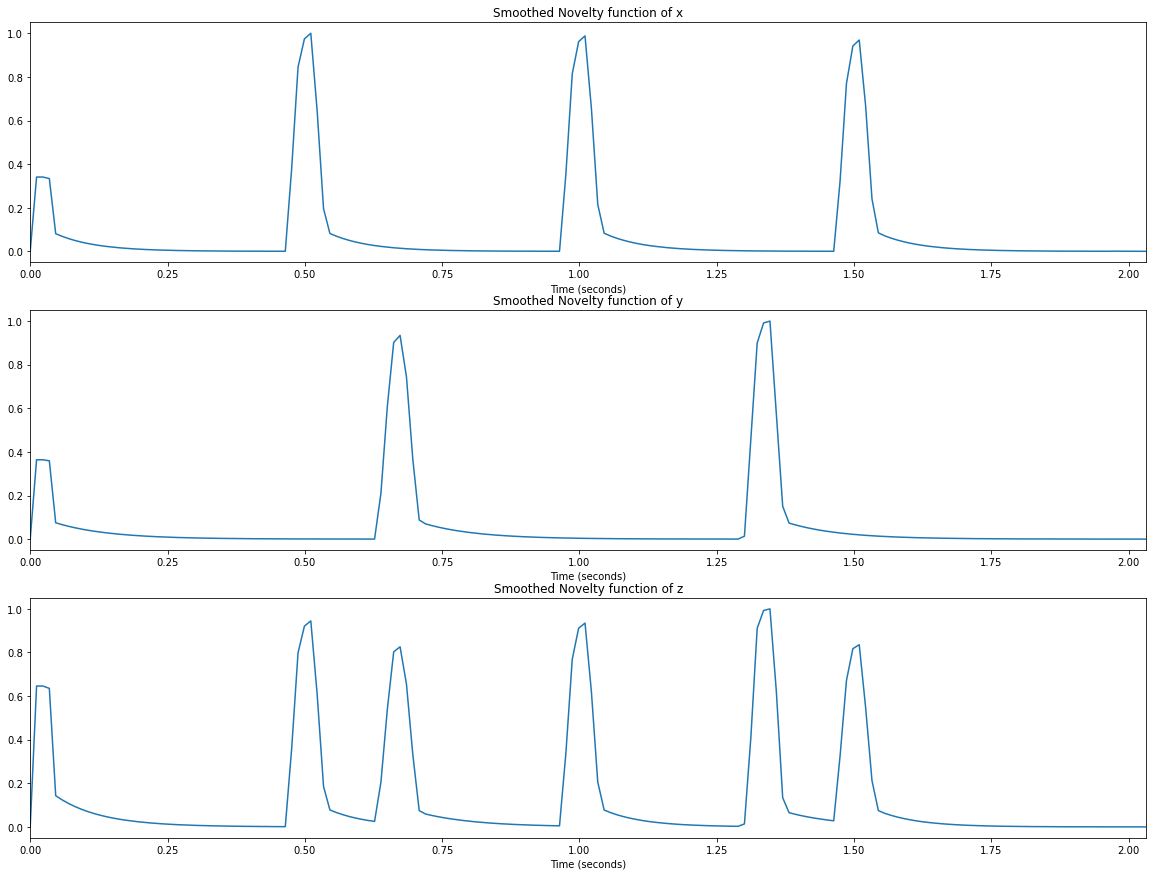

In [74]:
#Plot the smoothed novelty function
feature_time_axis = np.arange(smooth_nov_z.shape[0]) / Fs_nov

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Smoothed Novelty function of x')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, smooth_nov_x)

plt.subplot(3,1,2)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Smoothed Novelty function of y')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, smooth_nov_y)

plt.subplot(3,1,3)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Smoothed Novelty function of z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, smooth_nov_z)

plt.show()

### Add constant noise

In [75]:
#Generate constant noise
noise = 0.02 + 0*np.random.randn(len(smooth_nov_x))

In [76]:
#Add noise to the smoothed novelty function
noisy_smooth_nov_x = smooth_nov_x + noise
noisy_smooth_nov_y = smooth_nov_y + noise
noisy_smooth_nov_z = smooth_nov_z + noise

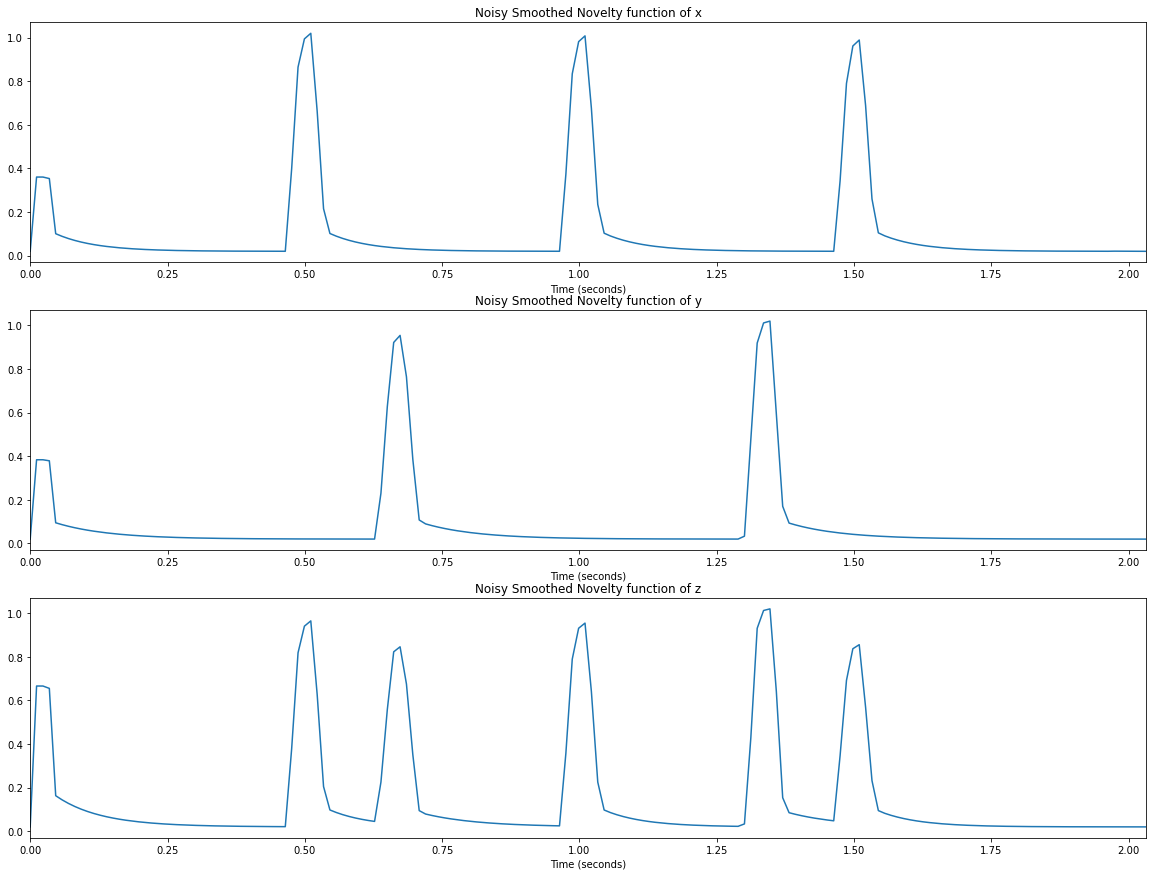

In [77]:
#Plot the noisy smoothed novelty function
feature_time_axis = np.arange(noisy_smooth_nov_z.shape[0]) / Fs_nov

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Noisy Smoothed Novelty function of x')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, noisy_smooth_nov_x)

plt.subplot(3,1,2)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Noisy Smoothed Novelty function of y')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, noisy_smooth_nov_y)

plt.subplot(3,1,3)
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Noisy Smoothed Novelty function of z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, noisy_smooth_nov_z)

plt.show()

### Compute APM

In [78]:
#Compute APM
P_x = compute_APM(noisy_smooth_nov_x, lags)
P_y = compute_APM(noisy_smooth_nov_y, lags)
P_z = compute_APM(noisy_smooth_nov_z, lags)

print("Shape of x:",P_x.shape)
print("Shape of y:",P_y.shape)
print("Shape of z:",P_z.shape)

Shape of x: (111, 129)
Shape of y: (111, 129)
Shape of z: (111, 129)


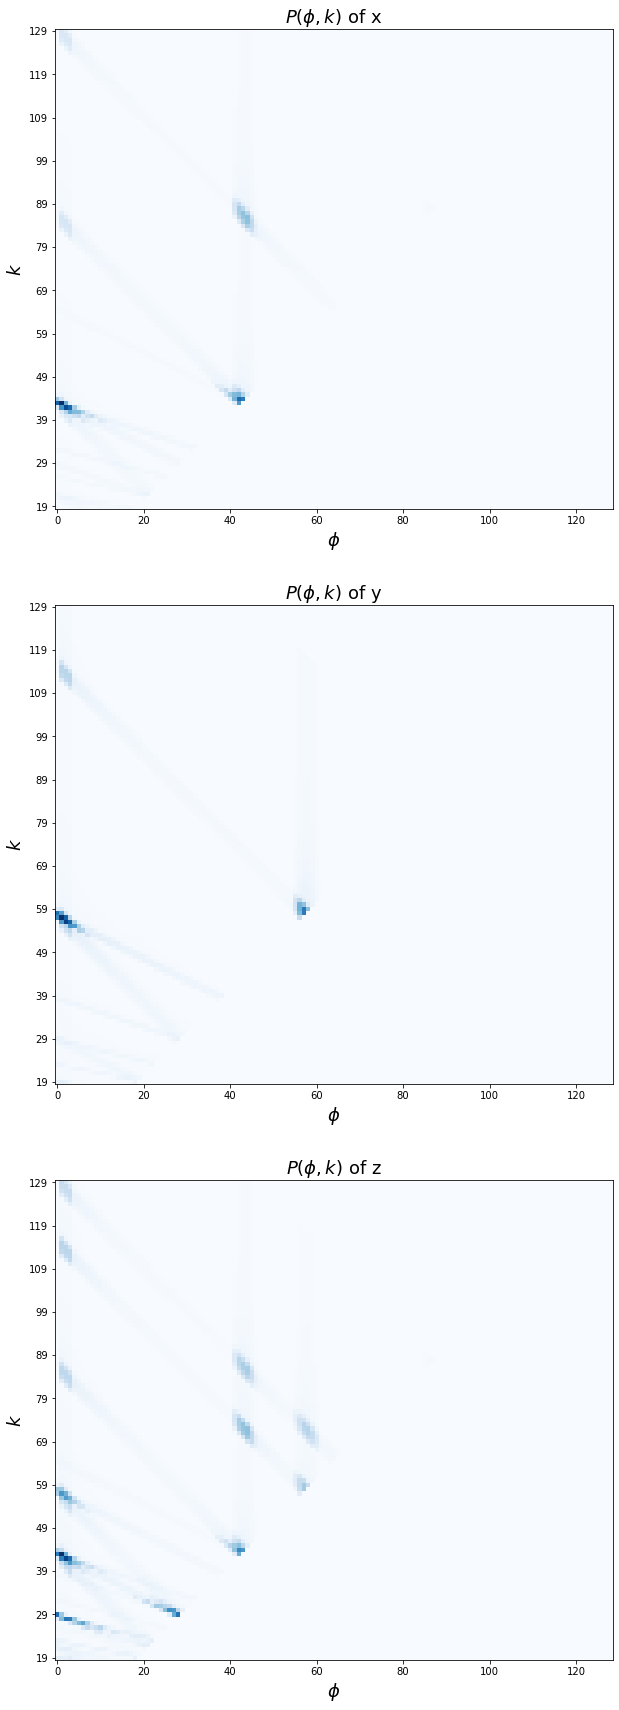

In [79]:
#Plot the APMs
plt.figure(figsize=(20,30))
plt.subplot(3,1,1)
plt.imshow(P_x, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 10), lags[::10])
plt.title(r'$P(\phi, k)$ of x', fontsize=18)

plt.subplot(3,1,2)
plt.imshow(P_y, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 10), lags[::10])
plt.title(r'$P(\phi, k)$ of y', fontsize=18)

plt.subplot(3,1,3)
plt.imshow(P_z, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 10), lags[::10])
plt.title(r'$P(\phi, k)$ of z', fontsize=18)
plt.show()

## Autocorrelation Phase Matrix Tempo Analysis

In [80]:
#Function to estimate the BPM given the APM and novelty rate
def BPM_estimation(APM,Fs, lags):
    n_k = APM.shape[0]
    kmin= lags[0]
    max_k = 0;
    max_APM = 0;
    
    #Look at which K is associated the higher peak of APM
    for k in np.arange(n_k):
        for phi in np.arange(k):
            if(APM[k,phi] > max_APM):
                max_APM = APM[k,phi];
                max_k = k + kmin
                
    BPM = np.around(60/(1/Fs*max_k))
    
    return BPM

In [81]:
#Estimate the BPM
BPM_x = BPM_estimation(P_x,Fs_nov, lags)
BPM_y = BPM_estimation(P_y,Fs_nov, lags)

print("Estimated BPM of X:", BPM_x,"BPM")
print("Estimated BPM of Y:", BPM_y,"BPM")

Estimated BPM of X: 120.0 BPM
Estimated BPM of Y: 91.0 BPM


## Autocorrelation Phase Matrix Rhythmic Analysis

In [82]:
import numpy as np
apm_dict = np.load('apm_dict.npy', allow_pickle=True).item()

In [83]:
#Extract the APM
apm_6 = apm_dict["apm"]
kmin_6 = apm_dict["k"][0]
kmax_6 = apm_dict["k"][-1]
lags_6 = apm_dict["k"]

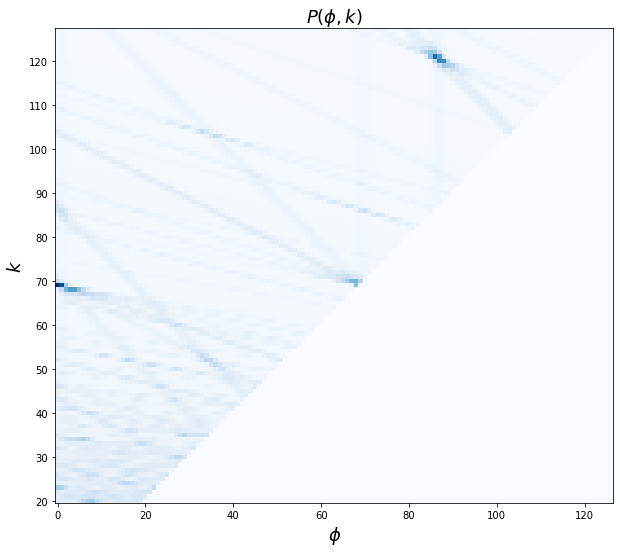

In [84]:
#Plot APM
plt.figure(figsize=(10,10))
plt.imshow(apm_dict["apm"], cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax_6 - kmin_6, 10), lags_6[::10])
plt.title(r'$P(\phi, k)$', fontsize=18)
plt.show()

In [85]:
#Function to extract the (k,phi) of the peaks of APM
def k_phi_extrac(APM, lags):
    
    max_val = []
    phi = []
    kmin = lags[0]
    
    #Get the max of each row
    for k in np.arange(APM.shape[0]):
        max_val.append(np.max(APM[k,:]))

    #Get the peaks on the row
    peaks = find_peaks(max_val, height=1)
    k = peaks[0]
    
    #Extract the phi position of the peaks
    for i in range(len(peaks)):
        phi.append(np.argmax(APM[k[i],:]))
    
    #Add the kmin
    k += kmin
    
    return k,phi

In [86]:
#Function to convert APM in possible trains of pulses
def get_pulses(APM, lags):

    kmin = lags[0]
    kmax = lags[-1]
    
    #Actual train of pulses
    pulses = []
    
    #Indicies of frames where a pulse has been added
    index = []
    
    #Extract k and phi
    k,phi = k_phi_extrac(APM, lags)
    
    i = 0
    flag = 0
    
    #Cicle to write the train of pulses and keep 2 cicles of the rhythm
    while(flag < 2):
        if ((i - phi[0]) % k[0] == 0 and (i - phi[1]) % k[1] == 0 ):
            flag +=1
            if(flag >= 2):
                break
        if ((i - phi[0]) % k[0] == 0 or (i - phi[1]) % k[1] == 0 ):
            if ((i+1 - phi[0]) % k[0] == 0 or (i+1 - phi[1]) % k[1] == 0 ):
                flag+=1 
                if(flag >= 2):
                    break   
            pulses.append(1)
            index.append(i)
            
        else:
            pulses.append(0)
        i+=1
        
    return pulses,indicies

In [94]:
#Get the train of pulses from the APM
pulses = get_pulses(apm_6, lags_6)[0]

indicies = get_pulses(apm_6, lags_6)[1]

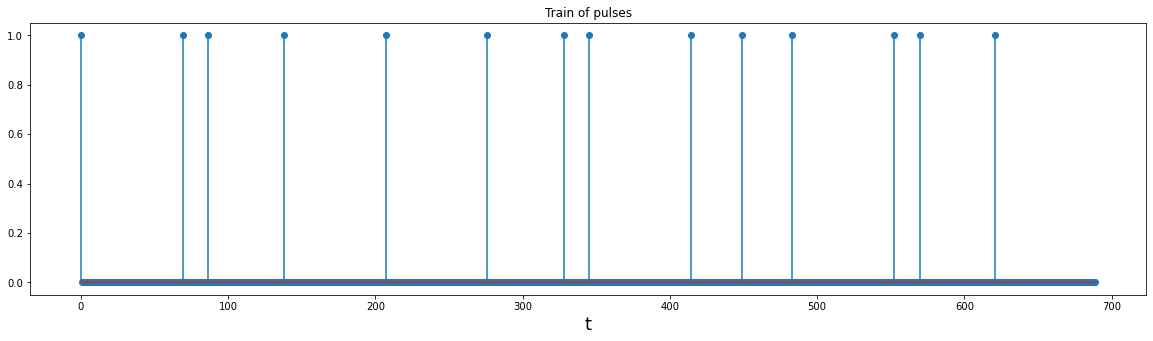

In [95]:
#Plot the pulses
plt.figure(figsize=(20, 5))
plt.stem(pulses, use_line_collection=True)
plt.xlabel('t', fontsize=18)
plt.title("Train of pulses")
plt.show()

In [89]:
#Convert the indicies in temporal position, assuming the hop lenght
times = librosa.frames_to_time(indicies, sr=22050, hop_length = 256)

click_track = librosa.clicks(sr=22050, times = times)

In [90]:
#Listen the result
ipd.display(ipd.Audio(click_track, rate=22050))